In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
# Calculate the date 1 year ago from the last data point in the database
last_day = session.query(func.max(Measurement.date)).scalar()
last_day

'2017-08-23'

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
last_year = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date > (dt.datetime.strptime(last_day, '%Y-%m-%d') - dt.timedelta(days=365))).\
    all()

In [12]:
# Perform a query to retrieve the data and precipitation scores
last_year_df = pd.DataFrame(last_year, columns=['date', 'precipitation'])
last_year_df.head()

,date,precipitation
0,2016-08-24,0.08
1,2016-08-25,0.08
2,2016-08-26,0.00
3,2016-08-27,0.00
4,2016-08-28,0.01


In [13]:
# Sort the dataframe by date
last_year_df_sort = last_year_df.sort_values(by='date')

In [14]:
# Save the query results as a Pandas DataFrame and set the index to the date column
last_year_by_date = last_year_df_sort.set_index('date')

In [15]:
last_year_by_date.head()

,precipitation
date,
2016-08-24,0.08
2016-08-24,NaN
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,2.15


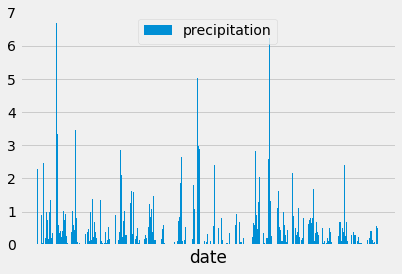

In [17]:
# Use Pandas Plotting with Matplotlib to plot the data
plt.bar(last_year_by_date.index, last_year_by_date['precipitation'])
plt.xticks([], [])
plt.xlabel('date')
plt.legend(['precipitation'], loc='upper center')

In [18]:
# Use Pandas to calcualte the summary statistics for the precipitation data
last_year_df.describe()

,precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [19]:
# Design a query to show how many stations are available in this dataset?
station_num = session.query(Station).count()
station_num

9

In [20]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
popular_station = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()
for row in popular_station:
    print(row)

('USC00519281', 2772)
('USC00519397', 2724)
('USC00513117', 2709)
('USC00519523', 2669)
('USC00516128', 2612)
('USC00514830', 2202)
('USC00511918', 1979)
('USC00517948', 1372)
('USC00518838', 511)


In [21]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
popular_station_temp = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.station == 'USC00519281').all()

popular_station_temp

[(54.0, 85.0, 71.66378066378067)]

In [22]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
popular_station_last_year = session.query(Measurement.tobs, func.count(Measurement.tobs)).\
    filter(Measurement.station == 'USC00519281').\
    filter(Measurement.date > (dt.datetime.strptime(last_day, '%Y-%m-%d') - dt.timedelta(days=365))).\
    group_by(Measurement.tobs).\
    all()

In [23]:
popular_station_last_year_df = pd.DataFrame(popular_station_last_year, 
                                           columns=['tobs', 'frequency'])
popular_station_last_year_df

,tobs,frequency
0,59.0,3
1,60.0,2
2,61.0,1
3,62.0,6
4,63.0,4
5,64.0,3
6,65.0,7
7,66.0,5
8,67.0,15
9,68.0,12


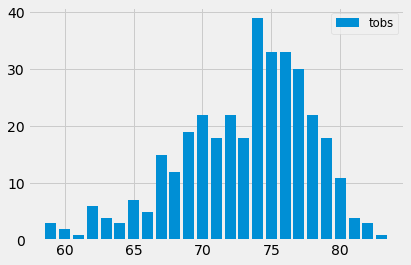

In [42]:
plt.bar(popular_station_last_year_df['tobs'], popular_station_last_year_df['frequency'])
plt.legend(['tobs'], loc="best", fontsize="small", fancybox=True)

In [27]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [28]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
print(calc_temps('2017-06-03', '2017-06-11'))

[(72.0, 77.36206896551724, 81.0)]


In [44]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
trip_df = pd.DataFrame(calc_temps('2017-06-03', '2017-06-11'), columns=['min', 'avg', 'max'])
trip_df

,min,avg,max
0,72.0,77.362069,81.0


([], <a list of 0 Text xticklabel objects>)

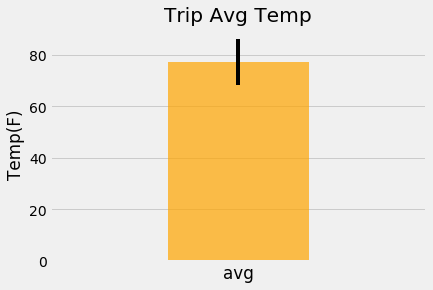

In [62]:
trip_df.plot(kind='bar', 
             y='avg', 
             width=0.3, 
             color='orange', 
             yerr=trip_df['max'] - trip_df['min'],
             title='Trip Avg Temp',
             alpha=0.7,
             legend=False,
             use_index=False)
plt.xlabel('avg')
plt.ylabel('Temp(F)')
plt.xticks([], [])

In [31]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
trip_start = '2017-06-03'
trip_end = '2017-06-11'
date_query = session.query(Measurement.station, Measurement.prcp, Measurement.tobs).\
    filter(Measurement.date >= trip_start).\
    filter(Measurement.date <= trip_end).all()
    
date_df = pd.DataFrame(date_query)

In [32]:
station_query = session.query(Station.station, Station.name, Station.latitude, Station.longitude).all()
station_df = pd.DataFrame(station_query)

In [33]:
place_df = pd.DataFrame(
    data={
        'station': date_df['station'].unique(),
        'prcp': date_df.groupby('station')['prcp'].sum(),
        'tobs_min': date_df.groupby('station')['tobs'].min(),
        'tobs_avg': date_df.groupby('station')['tobs'].mean(),
        'tobs_max': date_df.groupby('station')['tobs'].max()
    }
)

In [34]:
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
place_df.merge(station_df, how='left', on='station').sort_values(by=['prcp'], ascending=False)

,prcp,station,tobs_avg,tobs_max,tobs_min,name,latitude,longitude
4,1.64,USC00519523,74.777778,77.0,72.0,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139
2,1.54,USC00514830,75.125000,79.0,72.0,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740
1,0.91,USC00513117,79.777778,81.0,78.0,"KANEOHE 838.1, HI US",21.42340,-157.80150
0,0.84,USC00519397,75.777778,78.0,73.0,"WAIKIKI 717.2, HI US",21.27160,-157.81680
6,0.53,USC00516128,78.333333,81.0,75.0,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250
5,0.14,USC00519281,79.111111,80.0,77.0,"WAIHEE 837.5, HI US",21.45167,-157.84889
3,0.00,USC00517948,79.200000,80.0,78.0,"PEARL CITY, HI US",21.39340,-157.97510


## Optional Challenge Assignment

In [35]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [36]:
# Set the start and end date of the trip
trip_start_date = '06-03'
trip_end_date = '06-11'

# Loop through the list of %m-%d strings and calculate the normals for each date
trip_history = session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
    filter(func.strftime('%m-%d', Measurement.date) >= trip_start_date).\
    filter(func.strftime('%m-%d', Measurement.date) <= trip_end_date).\
    group_by(func.strftime('%m-%d', Measurement.date)).\
    all()
    
trip_history

[(65.0, 74.03448275862068, 80.0),
 (65.0, 73.81818181818181, 81.0),
 (68.0, 74.85454545454546, 81.0),
 (70.0, 75.17543859649123, 80.0),
 (68.0, 75.07142857142857, 81.0),
 (70.0, 75.58620689655173, 81.0),
 (69.0, 75.15254237288136, 81.0),
 (68.0, 75.14285714285714, 81.0),
 (69.0, 76.01960784313725, 84.0)]

In [37]:
# Use the start and end date to create a range of dates
trip_date_index = pd.date_range(start='6/3/2018', end='6/11/2018')
trip_date_index

DatetimeIndex(['2018-06-03', '2018-06-04', '2018-06-05', '2018-06-06',
               '2018-06-07', '2018-06-08', '2018-06-09', '2018-06-10',
               '2018-06-11'],
              dtype='datetime64[ns]', freq='D')

In [38]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
trip_history_df = pd.DataFrame(trip_history, columns=['tmin', 'tavg', 'tmax'], index=trip_date_index)
trip_history_df

,tmin,tavg,tmax
2018-06-03,65.0,74.034483,80.0
2018-06-04,65.0,73.818182,81.0
2018-06-05,68.0,74.854545,81.0
2018-06-06,70.0,75.175439,80.0
2018-06-07,68.0,75.071429,81.0
2018-06-08,70.0,75.586207,81.0
2018-06-09,69.0,75.152542,81.0
2018-06-10,68.0,75.142857,81.0
2018-06-11,69.0,76.019608,84.0


Text(0.5,0,'date')

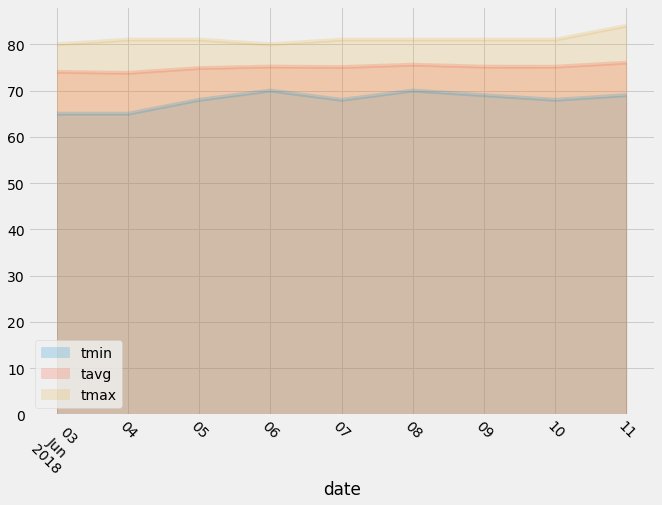

In [65]:
# Plot the daily normals as an area plot with `stacked=False`
trip_history_df.plot(kind='area', 
                     stacked=False, 
                     xticks=trip_history_df.index, 
                     rot=-45, 
                     alpha=0.2,
                     figsize=(10, 7))
plt.xlabel('date')